# Pump it up - Predicting the functionality of water pumps in Tanzania.

This project is a part of the [Data Driven competition](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/). Our goal is to predict the functionality of the water pumps in an effort to promote clean water access in communities across Tanzania. The data was provided by [Taarifa](http://taarifa.org) and Tanzanian Ministry of Water. The water pumps fall under one of the three classes - 
- `functional`: pump is operational and no repairs needed 
- `functional needs repair` pump is operational but needs repairs, and
- `non-functional`. pump is non-operational

Our aim is to predict the operating condition for each pump in the `holdout` dataset with high classification rate - 

\begin{equation}
Classification Rate = \frac{1}{N}\sum_{i=0}^{N}(y_i - \hat y_i)
\end{equation}
where $N$ is the number of rows, $y_i$ is the actual value of the class and $\hat y_i$ is the predicted value

## Download Datasets

The datasets for this project can be found [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/) (login required). There are 3 different datasets - *Training Set Labels*, *Training Set Values*, and *Test Set Values*. Lets download them and take a look.

In [1]:
import pandas as pd
from IPython.display import display
pd.set_option('display.max_columns',5000)
pd.set_option('display.max_rows', 5000)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
%matplotlib inline
sns.set_style('darkgrid')

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
def get_data(filename):
    '''Download the data using filename and returns the dataframe.'''
    
    df = pd.read_csv(filename)
    display(df.head())
    print('Dataframe has {} rows and {} columns' .format(df.shape[0], df.shape[1]))
    return df

train_X = get_data('Training-set-values.txt')
train_y = get_data('Training-set-labels.txt')
holdout = get_data('test-set.txt')


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


Dataframe has 59400 rows and 40 columns


,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


Dataframe has 59400 rows and 2 columns


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


Dataframe has 14850 rows and 40 columns


The dataframes `train_X` and `train_y` contain the independent and dependent values for the training dataset. It has 59400 rows with 40 columns in `train_X` and 2 columns in `train_y`. The `id` column is same for both dataframes. Besides the `id` column, the `train_y` column contains `status_group` column that displays the dependent variable (operating condition) for each row. The description of each column in `train_X` can be found [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/).

## Data Analysis

In [3]:
display(train_X.describe(include='all')) 
display(holdout.describe(include='all'))

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59400.000000,59400.000000,59400,55765,59400.000000,55745,59400.000000,5.940000e+04,59400,59400.000000,59400,59029,59400,59400.000000,59400.000000,59400,59400,59400.000000,56066,59400,55523,31234,56344,59400.000000,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,NaN,NaN,356,1897,NaN,2145,NaN,NaN,37400,NaN,9,19287,21,NaN,NaN,125,2092,NaN,2,1,12,2696,2,NaN,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,NaN,NaN,2011-03-15,Government Of Tanzania,NaN,DWE,NaN,NaN,none,NaN,Lake Victoria,Madukani,Iringa,NaN,NaN,Njombe,Igosi,NaN,True,GeoData Consultants Ltd,VWC,K,True,NaN,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,NaN,NaN,572,9084,NaN,17402,NaN,NaN,3563,NaN,10248,508,5294,NaN,NaN,2503,307,NaN,51011,59400,36793,682,38852,NaN,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625
mean,37115.131768,317.650385,NaN,NaN,668.297239,NaN,34.077427,-5.706033e+00,NaN,0.474141,NaN,NaN,NaN,15.297003,5.629747,NaN,NaN,179.909983,NaN,NaN,NaN,NaN,NaN,1300.652475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,21453.128371,2997.574558,NaN,NaN,693.116350,NaN,6.567432,2.946019e+00,NaN,12.236230,NaN,NaN,NaN,17.587406,9.633649,NaN,NaN,471.482176,NaN,NaN,NaN,NaN,NaN,951.620547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,NaN,NaN,-90.000000,NaN,0.000000,-1.164944e+01,NaN,0.000000,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,18519.750000,0.000000,NaN,NaN,0.000000,NaN,33.090347,-8.540621e+00,NaN,0.000000,NaN,NaN,NaN,5.000000,2.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,37061.500000,0.000000,NaN,NaN,369.000000,NaN,34.908743,-5.021597e+00,NaN,0.000000,NaN,NaN,NaN,12.000000,3.000000,NaN,NaN,25.000000,NaN,NaN,NaN,NaN,NaN,1986.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,55656.500000,20.000000,NaN,NaN,1319.250000,NaN,37.178387,-3.326156e+00,NaN,0.000000,NaN,NaN,NaN,17.000000,5.000000,NaN,NaN,215.000000,NaN,NaN,NaN,NaN,NaN,2004.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,14850.000000,14850.000000,14850,13981,14850.000000,13973,14850.000000,1.485000e+04,14850,14850.000000,14850,14751,14850,14850.000000,14850.000000,14850,14850,14850.000000,14029,14850,13881,7758,14113,14850.000000,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850
unique,NaN,NaN,331,980,NaN,1091,NaN,NaN,10840,NaN,9,8443,21,NaN,NaN,125,1959,NaN,2,1,11,1789,2,NaN,17,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,NaN,NaN,2013-02-03,Government Of Tanzania,NaN,DWE,NaN,NaN,none,NaN,Lake Victoria,Shuleni,Shinyanga,NaN,NaN,Njombe,Igosi,NaN,True,GeoData Consultants Ltd,VWC,K,True,NaN,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,communal standpipe,communal standpipe
freq,NaN,NaN,138,2215,NaN,4349,NaN,NaN,877,NaN,2623,140,1311,NaN,NaN,625,79,NaN,12738,14850,9124,176,9754,NaN,6483,6483,6483,10117,13048,6364,6364,12687,12687,8336,8336,4316,4316,11492,7106,8614
mean,37161.972929,322.826983,NaN,NaN,655.147609,NaN,34.061605,-5.684724e+00,NaN,0.415084,NaN,NaN,NaN,15.139057,5.626397,NaN,NaN,184.114209,NaN,NaN,NaN,NaN,NaN,1289.708350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,21359.364833,2510.968644,NaN,NaN,691.261185,NaN,6.593034,2.940803e+00,NaN,8.167910,NaN,NaN,NaN,17.191329,9.673842,NaN,NaN,469.499332,NaN,NaN,NaN,NaN,NaN,955.241087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,10.000000,0.000000,NaN,NaN,-57.000000,NaN,0.000000,-1.156459e+01,NaN,0.000000,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,18727.000000,0.000000,NaN,NaN,0.000000,NaN,33.069455,-8.443970e+00,NaN,0.000000,NaN,NaN,NaN,5.000000,2.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,37361.500000,0.000000,NaN,NaN,344.000000,NaN,34.901215,-5.049750e+00,NaN,0.000000,NaN,NaN,NaN,12.000000,3.000000,NaN,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,1986.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,55799.750000,25.000000,NaN,NaN,1308.000000,NaN,37.196594,-3.320594e+00,NaN,0.000000,NaN,NaN,NaN,17.000000,5.000000,NaN,NaN,220.000000,NaN,NaN,NaN,NaN,NaN,2004.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
display(train_X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

None

### Missing data

Seven categorical columns have missing values - `funder`, `installer`, `subvillage`, `public_meeting`, `scheme_management`, `scheme_name` and `permit`. In numerical variables, columns `construction_year` and `population` have missing values. They also have 0's as values in some of the rows that are probably data entry errors/missing data. Column `num_private` has a lot of 0's too but since there is no description provided for it we will ignore it.

Step1 - Replace the 0's in `population`, `construction_year`, `funder` and `installer` columns with np.nan. Replace the *Not Known* in `funder` and `installer` with np.nan. 

Step2 - Look at missing columns 

In [5]:
print(train_X['funder'].unique().tolist()) #check the unique values, tolist avoids truncation of the array while displaying

['DMDD', 'DWE', nan, 'FINN WATER', 'BRUDER', 'Gover', 'FinW', 'LGA', 'Lawatefuka water sup', 'CES', 'World vision', 'Building works company Ltd', 'DANID', '0', 'MWE &', 'BFFS', 'Dmdd', 'TLC', 'Central govt', 'DANIDA', 'Jaica', 'World Bank', 'Rotary club', 'Central Government', 'Morovian', 'ISF/Government', 'RC Church', 'Government', 'Hesawa', 'TWESA', 'Grobal resource alliance', 'District council', 'KKKT', 'Adra', 'Gove', 'Water aid /sema', 'Community', 'Centr', 'RC', 'District Council', 'IDYDC', 'Ki', 'Consuting Engineer', 'Commu', 'Kuwait', 'HESAWA', 'WEDECO', 'SI', 'LVA Ltd', 'Villagers', 'KADP', 'Village Council', 'TDFT', 'Norad', 'Mviwa', 'WU', 'Villa', 'MINISTRY OF WATER', 'Oikos E .Africa', 'M', 'MA', 'Plan Internationa', 'GOVER', 'MWS', 'Kiliwater', 'DWSP', 'College', 'Angli', 'DAWASCO', 'Barry A.Murphy', 'SHAWASA', 'AICT', 'Magadini-Makiwaru wa', 'Roman Church', 'DDCA', 'Da', 'Fini water', 'CEFA', 'CARE/CRC', 'Ir', 'Tardo', 'Shipo', 'WATERAID', 'CJEJOW CONSTRUCTION', 'Missi', 

In [21]:
def replace_vals(df, to_replace, value = np.nan, regex_set =0):
    '''Replace value in 'to_replace' with 'value' in dataframe'.
       Args:
           df (dataframe): input dataframe with only the columns being updated 
           to_replace(any): value to replace
           value(optional): value to replace with. np.nan unless other specified
      '''
    if regex_set == 0:
        df = df.replace(to_replace=to_replace, value=value)
    else:
        df = df.replace(to_replace=to_replace, value=value, regex=True)
    return df

def missing_data(df):
    '''Returns columns with missing values.
       Args:
           df (dataframe): input dataframe
       Return:
           Series: Column names with number of missing values'''
    all_cols = df.isna().sum()
    missing_cols = all_cols[all_cols != 0]
    return missing_cols

In [28]:
columns_replace = ['population', 'construction_year']
train_X[columns_replace] = replace_vals(train_X[columns_replace], 0)
holdout[columns_replace] = replace_vals(holdout[columns_replace], 0, np.nan)

In [29]:
columns_replace = ['funder', 'installer']
train_X[columns_replace] = replace_vals(train_X[columns_replace], '0')
holdout[columns_replace] = replace_vals(holdout[columns_replace], '0')
train_X[columns_replace] = replace_vals(train_X[columns_replace], r'[Nn]ot [Kk]nown', np.nan, 1)
holdout[columns_replace] = replace_vals(holdout[columns_replace], r'[Nn]ot [Kk]nown', np.nan, 1)

In [35]:
#check for missing values
missing_cols = missing_data(train_X)
print(missing_cols.sort_values(),'\n')

print(missing_data(holdout).sort_values())

subvillage             371
permit                3056
public_meeting        3334
scheme_management     3877
funder                4439
installer             4473
construction_year    20709
population           21381
scheme_name          28166
dtype: int64 

subvillage             99
permit                737
public_meeting        821
scheme_management     969
funder               1077
installer            1086
construction_year    5260
population           5453
scheme_name          7092
dtype: int64


<AxesSubplot:>

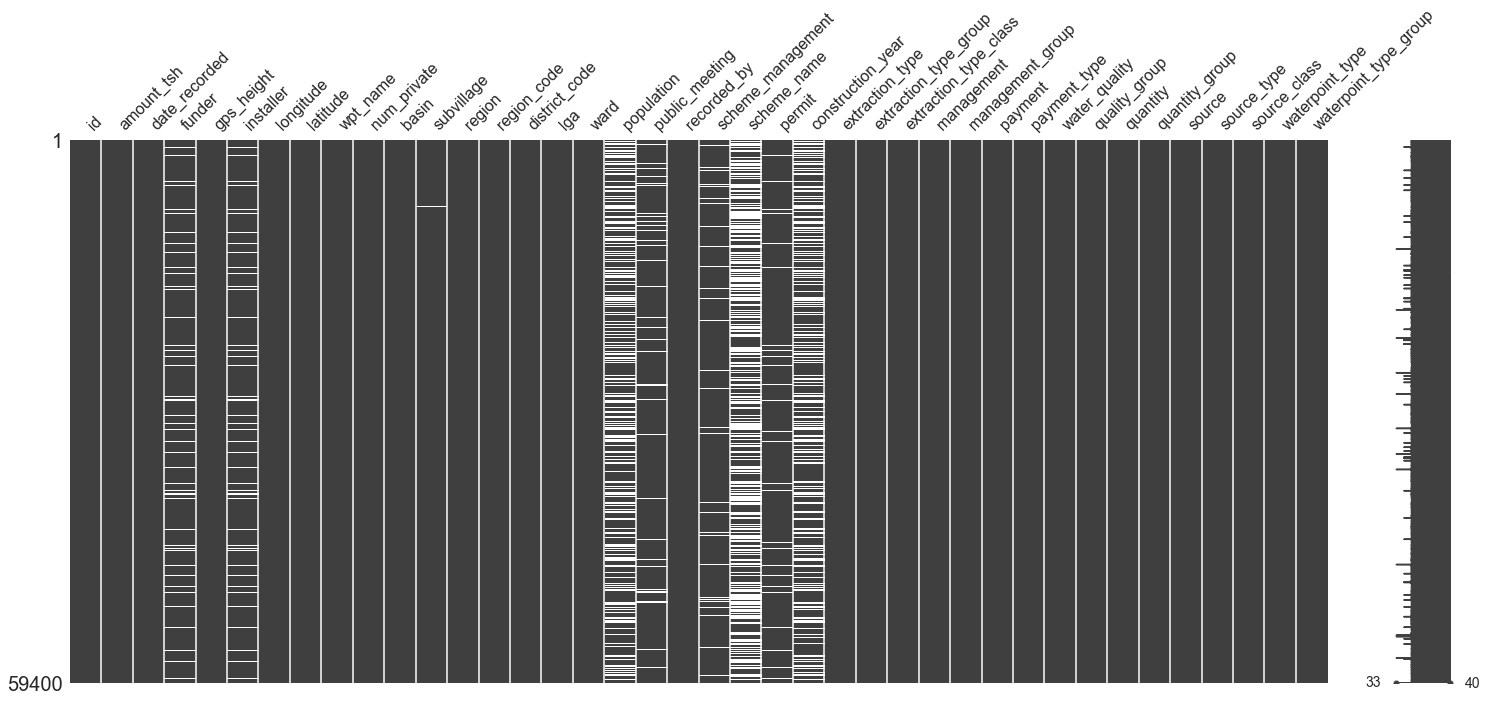

In [31]:
msno.matrix(train_X)

We can see that columnd `construction_year`, `population` and `scheme_name` have plenty of missing values. Columns `funder` and `installer` show correlation between the missing values (i.e. both columns have missing values in the same rows). 

In [32]:
#Missing values columns description only
train_X[missing_cols.index].describe(include='all')

,funder,installer,subvillage,population,public_meeting,scheme_management,scheme_name,permit,construction_year
count,54961,54927,59029,38019.000000,56066,55523,31234,56344,38691.000000
unique,1895,2142,19287,NaN,2,12,2696,2,NaN
top,Government Of Tanzania,DWE,Madukani,NaN,True,VWC,K,True,NaN
freq,9084,17402,508,NaN,51011,36793,682,38852,NaN
mean,NaN,NaN,NaN,281.087167,NaN,NaN,NaN,NaN,1996.814686
std,NaN,NaN,NaN,564.687660,NaN,NaN,NaN,NaN,12.472045
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1960.000000
25%,NaN,NaN,NaN,40.000000,NaN,NaN,NaN,NaN,1987.000000
50%,NaN,NaN,NaN,150.000000,NaN,NaN,NaN,NaN,2000.000000
75%,NaN,NaN,NaN,324.000000,NaN,NaN,NaN,NaN,2008.000000


Columns `scheme_name` has over 45% of values missing. This column describes who operates the waterpoint. A similar column (`scheme_management`) also exists for the same purpose. So we can safely ignore the column without losing any information. 

Columns `funder`, `installer`, `public_meetings`, `scheme_management`, `permit` are *categorical* columns with less than 8% missing values. We will replace them with mode of the column.

In [36]:
#Fill missing values
def process_missing_cat(df):
    '''Fill missing values in categorical columns.'''
    
    df['funder'].fillna(value='Government of Tanzania', inplace=True)
    df['installer'].fillna(value='DWE', inplace=True)
    df['public_meeting'].fillna(value=True, inplace=True)
    df['scheme_management'].fillna(value='VWC', inplace=True)
    df['permit'].fillna(value=True, inplace=True)
    return df

train_X = process_missing_cat(train_X)
holdout = process_missing_cat(holdout)

To replace the missing values in `subvillage`, we decided to use the most occuring `subvillage` value based on the `region` column (**Dodoma** and **Mwanza**) where the missing subvillages are located.

As seen below, the most occuring subvillage in **Mwanza** region gives us a value **1** which is probably a data entry error. A further look into the column shows plenty of data transcription errors (values with a single letter/digit). We will ignore the column from further analysis. Besides, `aubvillage` represents the region where the waterpoint is located and there are many other region based columns in the dataframe. So we are no losing any information.

In [37]:
print('Missing subvillages are located in the following regions', train_X['region'][train_X['subvillage'].isna()].unique())

print('Most occuring subvillage in Dodoma is', train_X['subvillage'][train_X['region'] == 'Dodoma'].value_counts(ascending=False).index[0])

print('Most occuring subvillage in Mwanza is', train_X['subvillage'][train_X['region'] == 'Mwanza'].value_counts().index[0])

display(train_X['subvillage'])

Missing subvillages are located in the following regions ['Dodoma' 'Mwanza']
Most occuring subvillage in Dodoma is Kawawa
Most occuring subvillage in Mwanza is 1


0            Mnyusi B
1             Nyamara
2             Majengo
3          Mahakamani
4          Kyanyamisa
             ...     
59395        Kiduruni
59396        Igumbilo
59397       Madungulu
59398          Mwinyi
59399    Kikatanyemba
Name: subvillage, Length: 59400, dtype: object

Lets take a look at the `Population` column - According to the [website](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/), this column describes the population around the well. 36% of its value is missing. It has a large range of values with 30500 being the maximum and 1 the mininum value. Not exactly sure how to handle missing values here. Should we normalize the data before handling missing values?

In [38]:
display(train_X['population'].describe())

count    38019.000000
mean       281.087167
std        564.687660
min          1.000000
25%         40.000000
50%        150.000000
75%        324.000000
max      30500.000000
Name: population, dtype: float64

Text(0.5, 1.0, 'Boxplot of population column without outliers')

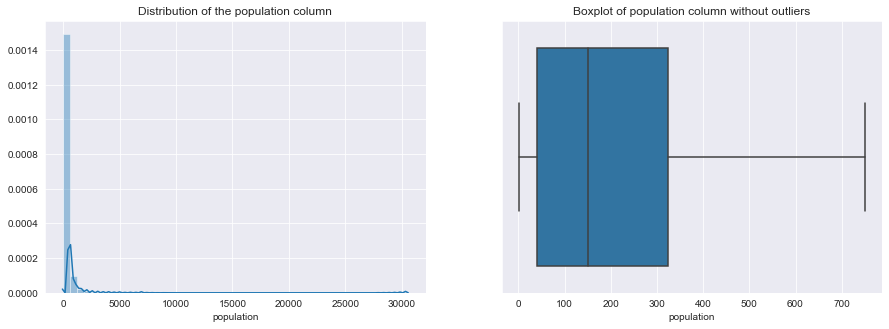

In [44]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,2,1)
sns.distplot(train_X['population'].dropna(), ax=ax1)
#sns.boxplot(train_y['status_group'], train_X['population'], ax=ax1, showfliers=False)
ax1.set_title('Distribution of the population column')
ax2 = plt.subplot(1,2,2)
sns.boxplot(train_X['population'].dropna(), ax=ax2, showfliers=False)
ax2.set_title('Boxplot of population column without outliers')

Column `construction_year`: The column has a skewed distribution (skewed to the left, i.e., negative skew). A median of 2000 indicates that equal number of handpumps were constructed between 2000 & 2013 as between 1960 & 2000. All years with maximum construction values were after the year 2000 with the maximum contruction happening in 2010. We will replace null values with the median.

In [45]:
#display top 10 years with maximum values
display(train_X['construction_year'].value_counts().sort_values(ascending=False).head(10))
display(train_X['construction_year'].describe())

2010.0    2645
2008.0    2613
2009.0    2533
2000.0    2091
2007.0    1587
2006.0    1471
2003.0    1286
2011.0    1256
2004.0    1123
2012.0    1084
Name: construction_year, dtype: int64

count    38691.000000
mean      1996.814686
std         12.472045
min       1960.000000
25%       1987.000000
50%       2000.000000
75%       2008.000000
max       2013.000000
Name: construction_year, dtype: float64

<AxesSubplot:xlabel='status_group', ylabel='construction_year'>

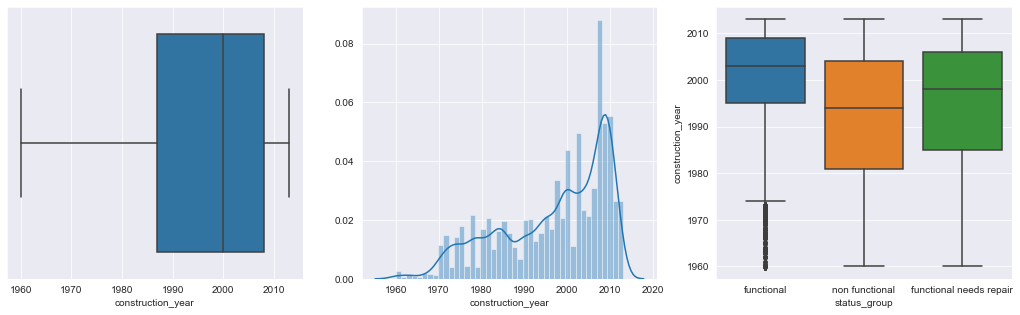

In [48]:
fig = plt.figure(figsize=(18,5))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
sns.boxplot(train_X['construction_year'].dropna(), ax=ax1)
sns.distplot(train_X['construction_year'].dropna(), ax=ax2)
sns.boxplot(train_y['status_group'], train_X['construction_year'], ax=ax3)

In [49]:
def process_missing_numerical(df, column_name):
    '''Fill missing values in numerical columns with the mean of the column'''
    df[column_name].fillna(value=int(df[column_name].median()), inplace=True)
    return df

train_X = process_missing_numerical(train_X, 'construction_year')
holdout = process_missing_numerical(holdout, 'construction_year')

<AxesSubplot:xlabel='status_group', ylabel='construction_year'>

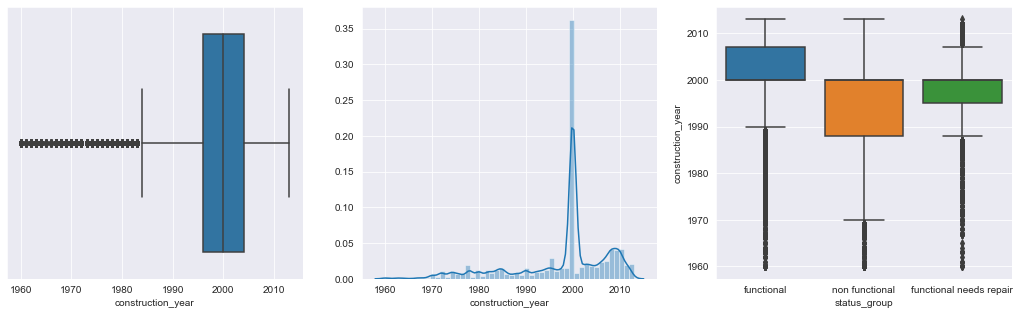

In [51]:
fig = plt.figure(figsize=(18,5))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
sns.boxplot(train_X['construction_year'], ax=ax1)
sns.distplot(train_X['construction_year'], ax=ax2)
sns.boxplot(train_y['status_group'], train_X['construction_year'], ax=ax3)

Lets look at the `amount_tsh` column. According to the description provided, it tells us the amount of water available to waterpoint. Over 50% of values are marked as 0, i.e. no water is available to pump. But that does not necessarily mean the handpump is non-functional. 

In [52]:
display(train_X['amount_tsh'].describe())

count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

Text(0.5, 1.0, 'Boxplot of amount_tsh for every pump label(without outliers)')

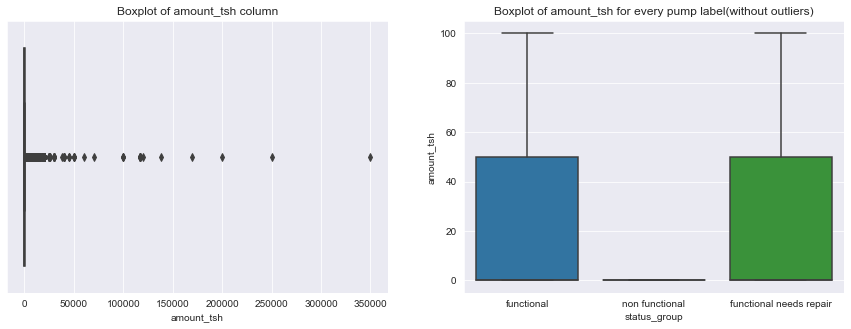

In [53]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
sns.boxplot(train_X['amount_tsh'], ax=ax1)
ax1.set_title('Boxplot of amount_tsh column')
sns.boxplot(train_y['status_group'], train_X['amount_tsh'], ax=ax2, showfliers=False)
ax2.set_title('Boxplot of amount_tsh for every pump label(without outliers)')

### Target Column

`status_group` - Over 90% of the pumps are either `functional` or `non-functional` with only 7% that are `functional needs repair` indicating that the classes are unbalanced.

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


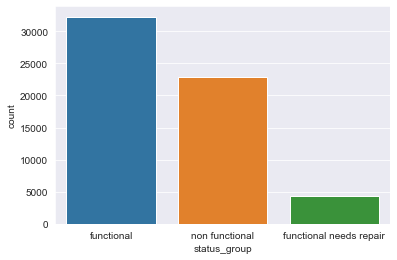

In [54]:
sns.countplot(train_y.status_group)
print(train_y['status_group'].value_counts())

Feature variables - Columns 'district_code' and 'region_code' are categorized as numeric but are categorical variables. Similarly, date_recorded is categorized as object but is datatime.

Lets look at some of the unique values of the categorical variables. Print top 10 unique values and number of unique values as well as a frequency plot some of the categorical columns.

In [56]:
cat_cols = train_X.select_dtypes(include = ['object', 'bool', 'category']).columns
cat_cols = cat_cols.drop('date_recorded')
for i in cat_cols:
    print(i,'-', len(train_X[i].unique()))
    print(train_X[i].value_counts()[:10])

funder - 1896
Government Of Tanzania    9084
Government of Tanzania    4439
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
Name: funder, dtype: int64
installer - 2142
DWE                   21875
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
TCRS                    707
Central government      622
CES                     610
Name: installer, dtype: int64
wpt_name - 37400
none               3563
Shuleni            1748
Zahanati            830
Msikitini           535
Kanisani            323
Bombani             271
Sokoni              260
Ofisini             254
School              208
Shule Ya Msingi     199
Name: wpt_name, dtype: int64
basin - 9
Lake Victoria             

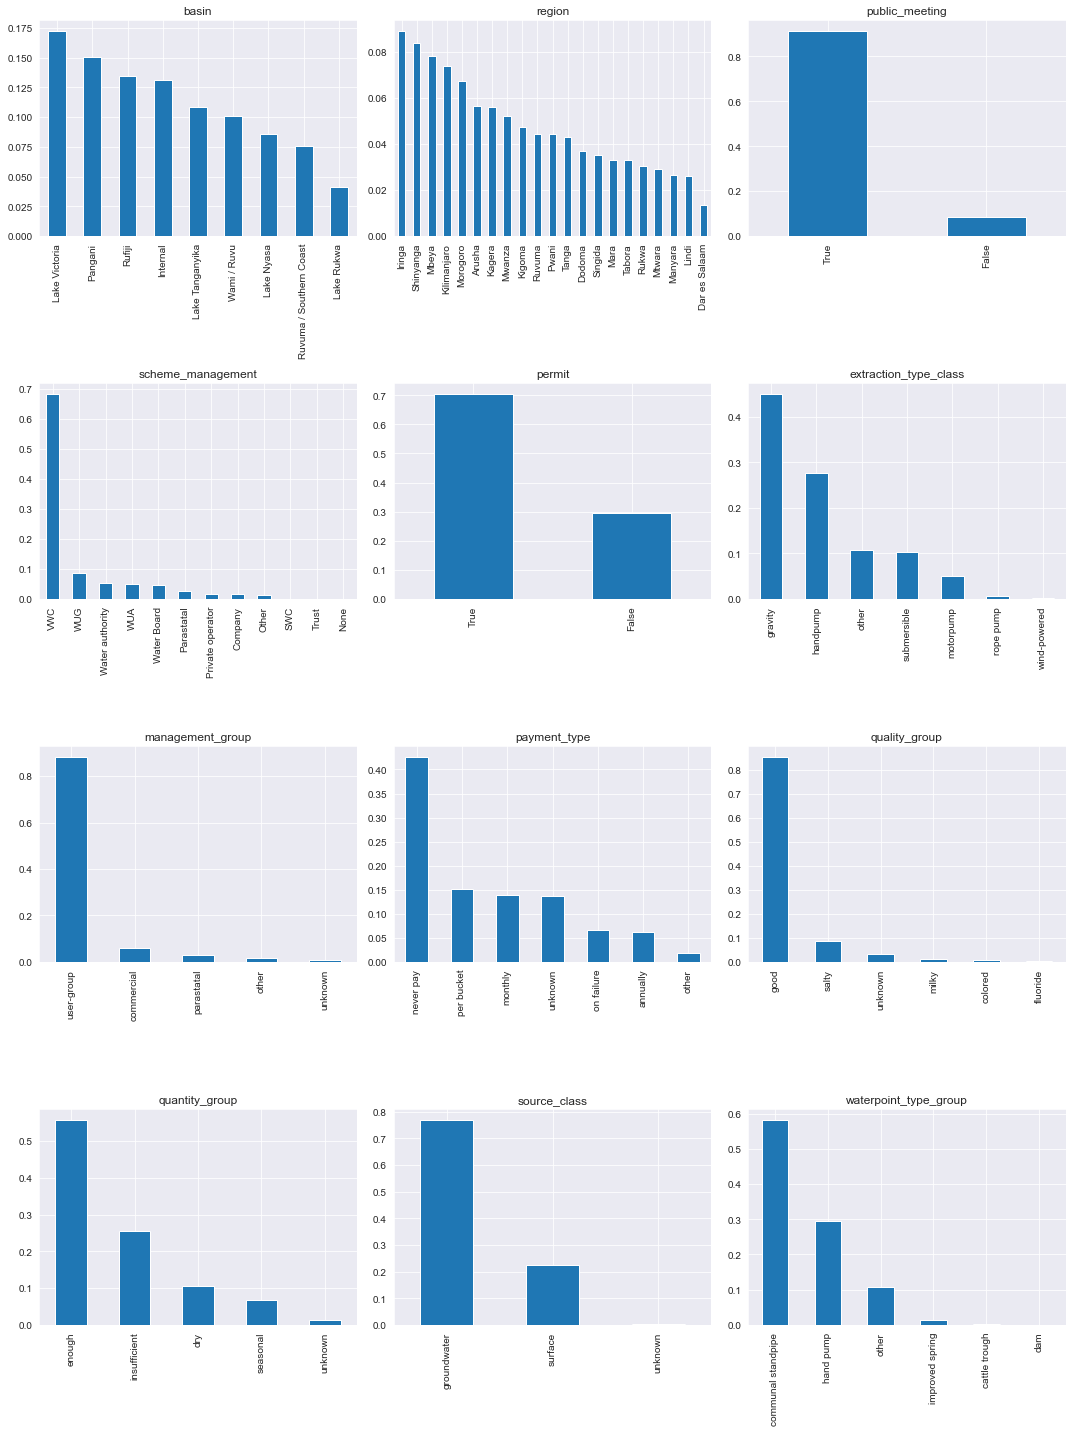

In [110]:
cols_to_plot = ['basin', 'region', 'public_meeting', 'scheme_management', 'permit', 
                'extraction_type_class', 'management_group', 'payment_type', 'quality_group', 
                'quantity_group', 'source_class', 'waterpoint_type_group'
               ]
fig = plt.figure(figsize=(15,20))
for i in range(1, 13):
    ax = plt.subplot(4,3,i)
    train_X[cols_to_plot[i-1]].value_counts(normalize=True).plot(kind = 'bar')
    ax.set_title('{}'.format(cols_to_plot[i-1]))
    
plt.tight_layout()

Majority of the water pumps are communal standpipe that uses groundwater to source water. More than 80% of the pumps supply 'good quality' water. 90% of these are managed by the users and over 40% of them never pay for the water.

In [ ]:
#merge above columns with status_groups to create a pivot table

## Feature Extraction 

Extract year from date_recorded and subtract from construction_year. This gives us the exact age of the wpt when the information was recorded. 

In [57]:
def process_age(df):
    year_recorded = df['date_recorded'].str.extract('(\d+)', expand=False).astype('int')
    df['age_wpt'] = year_recorded - df['construction_year']
    return df

train_X = process_age(train_X)
holdout = process_age(holdout)
display(train_X.head())

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,age_wpt
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109.0,True,GeoData Consultants Ltd,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,12.0
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280.0,True,GeoData Consultants Ltd,Other,NaN,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,3.0
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250.0,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,4.0
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58.0,True,GeoData Consultants Ltd,VWC,NaN,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,27.0
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,NaN,True,GeoData Consultants Ltd,VWC,NaN,True,2000.0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,11.0


<AxesSubplot:xlabel='status_group', ylabel='age_wpt'>

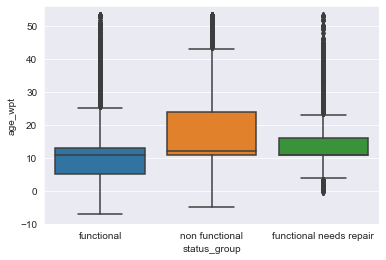

In [58]:
sns.boxplot(train_y['status_group'], train_X['age_wpt'])

Boxplot shows some relation between the status_group and age_wpt. The plot also shows some negative values for age_wpt. This means that the construction_year is after the date_recorded which cannot be correct. Drop those rows in both train_X and train_y. The same is true for holdout dataframe but the rows cannot be deleted as the submission file requires all 14850 rows.

In [59]:
def del_rows(df, index):
    '''Delete rows from dataframe'''
    
    df = df.drop(index=index)
    return df

idx = train_X[train_X['age_wpt'] < 0]['age_wpt'].index
print('Negative age_wpt rows in train_X') #to confirm that they are not a result of data imputation
display(train_X[['construction_year', 'date_recorded']].loc[idx])

train_X = del_rows(train_X, idx)
train_y = del_rows(train_y, idx)

print(train_X.shape, train_y.shape)

Negative age_wpt rows in train_X


,construction_year,date_recorded
8729,2008.0,2004-05-01
10441,2006.0,2004-12-01
13366,2011.0,2004-06-01
23373,2009.0,2004-03-01
27501,2009.0,2004-01-07
32619,2005.0,2004-03-01
33942,2007.0,2004-03-01
39559,2009.0,2004-03-06
48555,2008.0,2004-12-01


(59391, 41) (59391, 2)


Negative age_wpt rows in holdout


,construction_year,date_recorded
2922,2008.0,2004-01-04
7050,2011.0,2004-06-01
7718,2006.0,2004-06-01


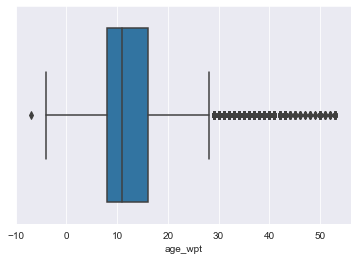

In [60]:
sns.boxplot(holdout['age_wpt'])
idx = holdout[holdout['age_wpt'] < 0]['age_wpt'].index
print('Negative age_wpt rows in holdout')
display(holdout[['construction_year', 'date_recorded']].loc[idx])

## Feature Selection

The first set columns not picked for model training based on 1) higher cardinality for categorical variables, 2) over 45%missing values, 3) not enough information about the column, 4)redundant information(e.g, there are a lot of region based columns, 4) scheme_management as it has different number of unique values in train and holdout dataframes.

In [61]:
#converting boolean dtypes to object (get_dummies function does not work for boolean types)
train_X[['public_meeting', 'permit']] = train_X[['public_meeting', 'permit']].astype('object')
train_X.info()

holdout[['public_meeting', 'permit']] = holdout[['public_meeting', 'permit']].astype('object')
holdout.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 59391 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59391 non-null  int64  
 1   amount_tsh             59391 non-null  float64
 2   date_recorded          59391 non-null  object 
 3   funder                 59391 non-null  object 
 4   gps_height             59391 non-null  int64  
 5   installer              59391 non-null  object 
 6   longitude              59391 non-null  float64
 7   latitude               59391 non-null  float64
 8   wpt_name               59391 non-null  object 
 9   num_private            59391 non-null  int64  
 10  basin                  59391 non-null  object 
 11  subvillage             59020 non-null  object 
 12  region                 59391 non-null  object 
 13  region_code            59391 non-null  int64  
 14  district_code          59391 non-null  int64  
 15  lg

In [62]:
def create_dummies(df, col_name):
    '''Replace categorical values with dummy values(One Hot Encoding) or LabelEncoding for prediction variable.'''
    if col_name == 'status_group':
        le = LabelEncoder()
        le.fit(df[col_name])
        print(le.classes_)
        df['status_group_enc'] = le.transform(df[col_name])
        return df
    else:
        dummies = pd.get_dummies(df[col_name], prefix=col_name)
        df = pd.concat([df,dummies], axis=1)
        return df
    
cat_cols = ['basin', 'region', 'public_meeting', 'permit', 'extraction_type_class', 'management_group', 'payment', 'quality_group', 'quantity_group','source_class', 'waterpoint_type_group']
train_X = create_dummies(train_X, cat_cols)
holdout = create_dummies(holdout, cat_cols)
train_y = create_dummies(train_y, 'status_group')
display(train_X.head())
display(holdout.head())
display(train_y.head(10))

['functional' 'functional needs repair' 'non functional']


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,age_wpt,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,public_meeting_False,public_meeting_True,permit_False,permit_True,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_group_dry,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109.0,True,GeoData Consultants Ltd,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,12.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280.0,True,GeoData Consultants Ltd,Other,NaN,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,3.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250.0,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58.0,True,GeoData Consultants Ltd,VWC,NaN,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,27.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,age_wpt,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,public_meeting_False,public_meeting_True,permit_False,permit_True,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_group_dry,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321.0,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012.0,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300.0,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000.0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,13.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
2,17168,0.0,2013-02-01,Government of Tanzania,1567,DWE,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500.0,True,GeoData Consultants Ltd,VWC,P,True,2010.0,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,3.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250.0,True,GeoData Consultants Ltd,VWC,NaN,True,1987.0,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,26.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
4,4987

,id,status_group,status_group_enc
0,69572,functional,0
1,8776,functional,0
2,34310,functional,0
3,67743,non functional,2
4,19728,functional,0
5,9944,functional,0
6,19816,non functional,2
7,54551,non functional,2
8,53934,non functional,2
9,46144,functional,0


In [63]:
train_X[cat_cols].describe()

,basin,region,public_meeting,permit,extraction_type_class,management_group,payment,quality_group,quantity_group,source_class,waterpoint_type_group
count,59391,59391,59391,59391,59391,59391,59391,59391,59391,59391,59391
unique,9,21,2,2,7,5,7,6,5,3,6
top,Lake Victoria,Iringa,True,True,gravity,user-group,never pay,good,enough,groundwater,communal standpipe
freq,10247,5293,54336,41905,26777,52483,25343,50810,33181,45786,34622


In [64]:
holdout[cat_cols].describe()

,basin,region,public_meeting,permit,extraction_type_class,management_group,payment,quality_group,quantity_group,source_class,waterpoint_type_group
count,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850
unique,9,21,2,2,7,5,7,6,5,3,6
top,Lake Victoria,Shinyanga,True,True,gravity,user-group,never pay,good,enough,groundwater,communal standpipe
freq,2623,1311,13559,10491,6483,13048,6364,12687,8336,11492,8614


Using Recursive Feature Elimination with cross-validation and Random Forest classifier as the estimator to select best features. I will not use the RFE for now and use all the columns apart from the ones that satisfy the criterion for feature selection.

Why Random Forest? It might help with the unbalanced label classes, non-normalized dataset (age_wpt vs dummy encoded categorical labels) and it will be less influenced by outliers.

In [75]:
def select_features(df, df_y):
    df_numeric = df.select_dtypes(include=['int64', 'float', 'uint8'])
    all_X = df_numeric.drop(columns=['id', 'amount_tsh', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year'])
    all_y = df_y['status_group_enc']
    #estimator = RandomForestClassifier(random_state=1)
    #selector = RFECV(estimator, step=2, cv=10)
    #selector.fit(all_X, all_y)
    #print('Best columns:\n', all_X.columns[selector.support_])
    #return all_X.columns[selector.support_]
    return all_X.columns

In [76]:
train_cols = select_features(train_X, train_y)

display(len(train_cols))

75

## Modeling

In [77]:
def select_params_rfc(train, test, features):
    all_X = train[features]
    all_y = test['status_group_enc']
    model = {
             'name': 'RandomForestClassifier',
             'estimator': RandomForestClassifier(),
             'hyperparameters': 
             {
                 'n_estimators': [100, 150],
                 'criterion': ['entropy', 'gini'],
                 'max_depth': [20, 40],
                 'max_features': ['log2', 'sqrt'],
                 'min_samples_leaf': [50, 30],
                 'min_samples_split': [50,30]
             }
            }
    best_param = {}
    print(model['name'])
    grid = GridSearchCV(model['estimator'], model['hyperparameters'], cv=6)
    grid.fit(all_X, all_y)
    best_param['name'] = model['name']
    best_param['score'] = grid.best_score_
    best_param['params'] = grid.best_params_
    best_param['estimator'] = grid.best_estimator_
    print(grid.best_score_, '\t', grid.best_params_)
    return best_param


Random Forest Classifier using GridSearchCV to calculate optimal parameters and hyperparameters.

In [78]:
import time
start = time.time()
best_param = select_params_rfc(train_X, train_y, train_cols)
print(time.time() - start)
print(best_param)

RandomForestClassifier
0.750955530497004 	 {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 30, 'n_estimators': 150}
2119.5427877902985
{'name': 'RandomForestClassifier', 'score': 0.750955530497004, 'params': {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 30, 'n_estimators': 150}, 'estimator': RandomForestClassifier(criterion='entropy', max_depth=40, max_features='sqrt',
                       min_samples_leaf=30, min_samples_split=30,
                       n_estimators=150)}


Feature importance using random forest estimator to check if any more features can be ignored.

Remove features with values less than 0.005 and re-run the select_parameters_rfc function to check if it improves the accuracy score.

In [79]:
from sklearn.metrics import f1_score, classification_report
model = best_param['estimator']
y_pred = model.predict(train_X[train_cols])
#f1_score(train_y['status_group_enc'], y_pred, average=None)
print(classification_report(train_y['status_group_enc'], y_pred))

              precision    recall  f1-score   support

           0       0.72      0.94      0.82     32255
           1       0.79      0.03      0.06      4317
           2       0.85      0.64      0.73     22819

    accuracy                           0.76     59391
   macro avg       0.79      0.54      0.54     59391
weighted avg       0.78      0.76      0.73     59391



In [81]:
model = best_param['estimator']
model.feature_importances_
features_series = pd.Series(model.feature_importances_, index=train_cols)
print(features_series.sort_values(ascending=False))
new_train_cols = features_series[features_series > 0.005].index
new_train_cols

quantity_group_dry                          0.213655
age_wpt                                     0.074300
waterpoint_type_group_other                 0.068555
extraction_type_class_other                 0.066296
quantity_group_enough                       0.050712
gps_height                                  0.044988
payment_never pay                           0.029168
extraction_type_class_gravity               0.028810
quantity_group_insufficient                 0.023922
region_Iringa                               0.020544
region_Shinyanga                            0.016713
waterpoint_type_group_communal standpipe    0.014843
waterpoint_type_group_hand pump             0.014809
extraction_type_class_handpump              0.014529
payment_pay per bucket                      0.014343
quality_group_unknown                       0.012400
payment_unknown                             0.011932
basin_Lake Victoria                         0.011666
source_class_surface                        0.

Index(['gps_height', 'age_wpt', 'basin_Internal', 'basin_Lake Nyasa',
       'basin_Lake Rukwa', 'basin_Lake Tanganyika', 'basin_Lake Victoria',
       'basin_Pangani', 'basin_Rufiji', 'basin_Ruvuma / Southern Coast',
       'basin_Wami / Ruvu', 'region_Iringa', 'region_Kigoma', 'region_Mbeya',
       'region_Shinyanga', 'public_meeting_False', 'permit_False',
       'permit_True', 'extraction_type_class_gravity',
       'extraction_type_class_handpump', 'extraction_type_class_motorpump',
       'extraction_type_class_other', 'extraction_type_class_submersible',
       'management_group_commercial', 'management_group_user-group',
       'payment_never pay', 'payment_pay annually', 'payment_pay monthly',
       'payment_pay per bucket', 'payment_unknown', 'quality_group_good',
       'quality_group_unknown', 'quantity_group_dry', 'quantity_group_enough',
       'quantity_group_insufficient', 'quantity_group_seasonal',
       'source_class_groundwater', 'source_class_surface',
       'wa

In [82]:

new_best_param = select_params_rfc(train_X, train_y, new_train_cols)


RandomForestClassifier
0.7510565984307064 	 {'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 30, 'n_estimators': 100}


In [83]:
model = new_best_param['estimator']
y_pred = model.predict(train_X[new_train_cols])
print(classification_report(train_y['status_group_enc'], y_pred))

              precision    recall  f1-score   support

           0       0.73      0.93      0.82     32255
           1       0.69      0.06      0.12      4317
           2       0.84      0.65      0.73     22819

    accuracy                           0.76     59391
   macro avg       0.75      0.55      0.55     59391
weighted avg       0.77      0.76      0.73     59391



In [118]:
#Calculating classification rate based on the primary evaluation metric of the competition.
print('The classification score using the above model is {}'.format((train_y['status_group_enc'] == y_pred).sum()/len(train_y)))

The classification score using the above model is 0.7596100419255443


Reducing the number of features does nothing to the accuracy but it shows some improvement in the f1-score for class 'functional need repair'. Using the new_model and new_target columns to predict classes for the holdout dataset.

In [84]:
def save_submission_file(model, features, filename='DrivenData-Pump it up.csv'):
    predicted = model.predict(holdout[features])
    encoded_class = {
                0: 'functional',
                1: 'functional needs repair',
                2: 'non functional'
                    }
    print(predicted)
    print(type(predicted))
    print(predicted.shape)
    wpt = pd.DataFrame({'id': holdout['id'],
                        'status_group_enc': predicted})
    wpt['status_group'] = wpt['status_group_enc'].map(encoded_class)
    wpt.drop(columns='status_group_enc', inplace=True)
    wpt.to_csv(filename, index=False)
    return 


In [85]:
model = best_param['estimator']
save_submission_file(model, train_cols)

[2 0 2 ... 0 0 2]
<class 'numpy.ndarray'>
(14850,)


## Summary

To summarize, we used Random Forest Classifier along with GridSearchCV to train our model and apply it to the holdout data. The accuracy score after submission was 0.754. However, due to unbalanced class size, `functional needs repair` has a low recall & f1-score. That means our model is giving a lot of false negatives for this class. We will have to come up with another way to deal with this problem if we want to further improve our model.